In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(42)

In [3]:
df = pd.read_csv("../datasets/consolidated_data/oil_data.csv", index_col="DATEPRD")

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)

date = df.index
scaled_oil_data = scaled_df.BORE_OIL_VOL.to_numpy()

split_date = 2140

date_train = date[:split_date]
date_test = date[split_date:]
oil_train = scaled_oil_data[:split_date]
oil_test = scaled_oil_data[split_date:]

print(oil_train.shape, oil_test.shape, date_train.shape, date_test.shape)

scaled_df.head()

(2140,) (916,) (2140,) (916,)


,BORE_OIL_VOL
DATEPRD,
2008-02-12,0.030164
2008-02-13,0.198133
2008-02-14,0.331061
2008-02-15,0.276400
2008-02-16,0.323400


In [4]:
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
        
#function to plot a series
def plot_series(x, y, type_=None, ylabel=None, format="-", start=None, end=None, label=None, multi_plot=True):
    if not multi_plot:
        plt.figure(figsize=(20, 10))
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date", labelpad=50, fontsize=14)
    plt.ylabel(f"{ylabel} Volume", labelpad=50, fontsize=14)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True, which='both')
    x_ticks = x.to_list()
    x_max = max(x_ticks)
    x_ticks = x_ticks[::round(len(x_ticks)/10)]
    x_ticks.append(x_max)
    plt.xticks(x_ticks, rotation = 90)
    if not multi_plot:
        plt.savefig(f'../plots/{ylabel.lower()}_{type_}_time_series.png')
        plt.show()


def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)

def train_model(train_dataset, validation_dataset, num_units):
    model = Sequential([
                    LSTM(num_units, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
                    LSTM(num_units, return_sequences=True, stateful=True),
                    Dense(1)
                    ])
    optimizer = keras.optimizers.SGD(
                    learning_rate=1e-3, 
                    momentum=0.9
                    )
    model.compile(
                loss=keras.losses.Huber(), 
                optimizer=optimizer, 
                metrics=["mae"]
                )
    
    reset_states = ResetStatesCallback()
    
    model_checkpoint = ModelCheckpoint(
                                "LSTM_oil_checkpoint.h5", 
                                save_best_only=True
                                )
    
    early_stopping = EarlyStopping(patience=50)
    
    model.fit(
            train_dataset, 
            epochs=500, 
            verbose=0,
            validation_data=validation_dataset,
            callbacks=[
                    early_stopping, 
                    model_checkpoint, 
                    reset_states
                    ]
            )

    return model

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:8])
    num_units_bits = BitArray(ga_individual_solution[8:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    refresh()

    oil_train_set = sequential_window_dataset(oil_train, window_size)
    oil_test_set = sequential_window_dataset(oil_test, window_size)
    
    # Train LSTM model and predict on validation set
    model = train_model(oil_train_set, oil_test_set, num_units)
    
    #load best model
    model = keras.models.load_model("LSTM_oil_checkpoint.h5")
    LSTM_oil_forecast = model.predict(scaled_oil_data[np.newaxis, :, np.newaxis])
    LSTM_oil_forecast = LSTM_oil_forecast[0, split_date - 1:-1, 0]

    # # Calculate the RMSE score as fitness score for GA
    mae = keras.metrics.mean_absolute_error(oil_test, LSTM_oil_forecast).numpy()
    mse = keras.metrics.mean_squared_error(oil_test, LSTM_oil_forecast).numpy()
    rmse = math.sqrt(mse)

    print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')
    
    return rmse,

In [ ]:
population_size = 4
num_generations = 4
gene_length = 12

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)

In [ ]:
best_individuals = tools.selBest(population, k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:8])
    num_units_bits = BitArray(bi[8:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)

In [ ]:
# Window Size:  194 , Num of Units:  143
# best_window_size = 194
# best_num_units = 143

refresh()

oil_train_set = sequential_window_dataset(oil_train, best_window_size)
oil_test_set = sequential_window_dataset(oil_test, best_window_size)

model = Sequential([
                LSTM(best_num_units, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
                LSTM(best_num_units, return_sequences=True, stateful=True),
                Dense(1)
                ])
optimizer = keras.optimizers.SGD(
                learning_rate=1e-3, 
                momentum=0.9
                )
model.compile(
            loss=keras.losses.Huber(), 
            optimizer=optimizer, 
            metrics=["mae"]
            )

reset_states = ResetStatesCallback()

model_checkpoint = ModelCheckpoint(
                            "LSTM_oil_checkpoint.h5", 
                            save_best_only=True
                            )

early_stopping = EarlyStopping(patience=50)

history = model.fit(
        oil_train_set, 
        epochs=500, 
        verbose=1,
        validation_data=oil_test_set,
        callbacks=[
                early_stopping, 
                model_checkpoint, 
                reset_states
                ]
        )

model = keras.models.load_model("LSTM_oil_checkpoint.h5")
LSTM_oil_forecast = model.predict(scaled_oil_data[np.newaxis, :, np.newaxis])
LSTM_oil_forecast = LSTM_oil_forecast[0, split_date - 1:-1, 0]

# # Calculate the RMSE score as fitness score for GA
mae = keras.metrics.mean_absolute_error(oil_test, LSTM_oil_forecast).numpy()
mse = keras.metrics.mean_squared_error(oil_test, LSTM_oil_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

Epoch 1/500
11/11 [==============================] - 15s 494ms/step - loss: 0.1090 - mae: 0.3636 - val_loss: 0.0088 - val_mae: 0.1185
Epoch 2/500
11/11 [==============================] - 3s 254ms/step - loss: 0.0667 - mae: 0.2617 - val_loss: 0.0028 - val_mae: 0.0538
Epoch 3/500
11/11 [==============================] - 3s 235ms/step - loss: 0.0399 - mae: 0.2172 - val_loss: 0.0094 - val_mae: 0.1207
Epoch 4/500
11/11 [==============================] - 3s 229ms/step - loss: 0.0304 - mae: 0.2048 - val_loss: 0.0158 - val_mae: 0.1648
Epoch 5/500
11/11 [==============================] - 2s 204ms/step - loss: 0.0272 - mae: 0.1994 - val_loss: 0.0174 - val_mae: 0.1745
Epoch 6/500
11/11 [==============================] - 2s 207ms/step - loss: 0.0254 - mae: 0.1929 - val_loss: 0.0160 - val_mae: 0.1669
Epoch 7/500
11/11 [==============================] - 2s 202ms/step - loss: 0.0241 - mae: 0.1862 - val_loss: 0.0141 - val_mae: 0.1553
Epoch 8/500
11/11 [==============================] - 2s 205ms/step -

In [5]:
model = keras.models.load_model("LSTM_oil_checkpoint.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 143)            82940     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 143)            164164    
_________________________________________________________________
dense (Dense)                (1, None, 1)              144       
Total params: 247,248
Trainable params: 247,248
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Plotting the loss model
plt.figure(figsize=(20, 10))
plt.plot(history.history["loss"])
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'../plots/optimized_loss_model.png')
plt.show()

TypeError: 'NoneType' object is not subscriptable

<Figure size 1440x720 with 0 Axes>

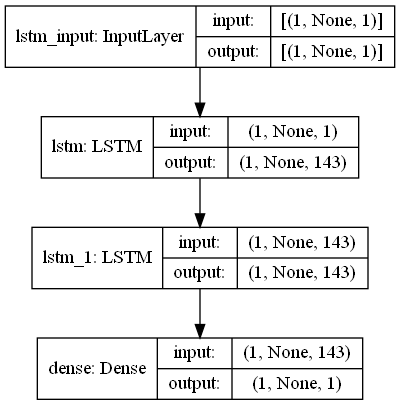

In [6]:
model = keras.models.load_model("LSTM_oil_checkpoint.h5")

# Model Architecture
keras.utils.plot_model(model, f'../plots/lstm_model_plot.png', show_shapes = True)

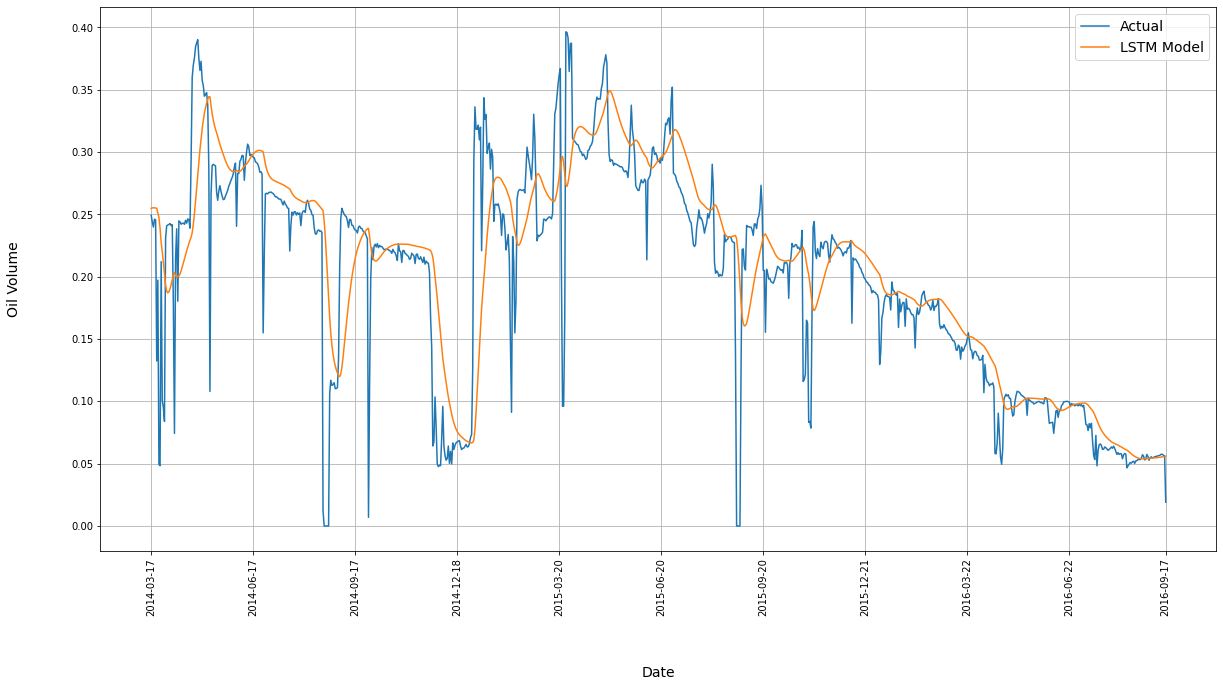

In [41]:
plt.figure(figsize=(20, 10))

plot_series(date_test, oil_test, ylabel="Oil", label="Actual")
plot_series(date_test, LSTM_oil_forecast, ylabel="Oil", label="LSTM Model")

plt.savefig(f'../plots/oil_predicted_time_series.png')
plt.show()